# Install needed libs

In [1]:
!pip install pyldavis
!pip install kneed
!pip install nltk
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libs

In [2]:
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.manifold import TSNE
from sklearn.cluster import (
    MiniBatchKMeans, 
    KMeans
)
from sklearn.decomposition import (
    PCA,
    LatentDirichletAllocation
)
from sklearn.feature_extraction.text import (
    TfidfVectorizer, 
    CountVectorizer
)
from sklearn.metrics import silhouette_score
from wordcloud import (
    WordCloud, 
    ImageColorGenerator
)
from PIL import Image
import urllib
import requests
import re
from kneed import KneeLocator
import nltk
from gensim.models.word2vec import Word2Vec
from gensim.models import CoherenceModel


nltk.download('punkt')
nltk.download('stopwords')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
build==0.10.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1
di

# Read Data

In [4]:
path = '/content/tweets.csv'

In [5]:
df = pd.read_csv(path)
df.head()

,username,date,tweet,mentions
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein']
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein']
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,['vodafonein']
3,sanjan_suman,10-06-2020,@VodafoneIN I have done my recharge of 555 on...,['vodafonein']
4,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,['vodafonein']


# Data inspection

## Sample data

In [6]:
df.tweet

0        Please check what happens to this no 940417705...
1        Network fluctuations and 4G Speed is pathetic....
2        This has been going on since 3rd... this absol...
3        @VodafoneIN  I have done my recharge of 555 on...
4        But when???Still I am not received any call fr...
                               ...                        
21042    I sent u my contact no. But still did not get ...
21043    dear @VodafoneIN  i have bn facing ur network ...
21044    rubbish i made many time @VodafoneIN  you didn...
21045    Why the caller tunes sound so horrible? if a s...
21046    @VodafoneIN @idea_cares what nonsense are u gu...
Name: tweet, Length: 21047, dtype: object

In [7]:
def replace_all(replacer: dict, value:str):
    for old, new in replacer.items():
        value = value.replace(old, new)
    return value

In [8]:
df.mentions = df['mentions'].str.lower()
df.mentions = df['mentions'].str.strip('][')
df.mentions = df['mentions'].str.replace("'",'')
df.mentions = df['mentions'].str.replace('"','')
df.mentions = df['mentions'].str.split(', ')

In [9]:
big_corps = ['google', 'facebook', 'netflix', 'vodafone', 'apple', 'amazon',
            'telecomtalk', 'finminindia', 'ascionline', 'airtel', 'ettelecom',
            'orange', 'americanair', 'dominos', 'wikitribune', 'sportify', 'bgrindia',
            'redmi', 'xiaomi', 'youtube']
gov_corps = ['consumerreports', 'israelipm', 'news18india', 'pmoindia',
            'timesofindia', 'finminindia', 'digitalindia', 'bsindia', 'ndtvindia',
            'hmoindia', 'mib_india', 'pib_india', 'tanla_india', 'indiatvnews'
                                                                 'indiatoday', 'mohfw_india', 'mygovindia',
            'indianexpress', 'myvodaindia',
            'doj_india', 'pcmcindiagovin', 'courtindia', 'startupindia', 'theprintindia']

total = big_corps + gov_corps


def process_mention(mentions):
    mention_list = []
    type_list = []
    for mention in mentions:
        flag = False
        for corp in big_corps:
            if corp in mention and flag == False:
                flag = True
                mention_list.append(corp)
                type_list.append('Corporation')
            continue

        for gov_corp in gov_corps:
            if gov_corp in mention and flag == False:
                flag = True
                mention_list.append(gov_corp)
                type_list.append('Government Related Corporation')
            continue

        if flag == False:
            mention_list.append(mention)
            type_list.append('Twitter User')
            continue

    return type_list, mention_list


def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

In [10]:
temp_df = df.copy(deep=True)
temp_df = apply_and_concat(df, 'mentions', process_mention, ['mentioned_type', 'mentioned'])
temp_df

,username,date,tweet,mentions,mentioned_type,mentioned
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,[vodafonein],[Corporation],[vodafone]
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,[vodafonein],[Corporation],[vodafone]
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,[vodafonein],[Corporation],[vodafone]
3,sanjan_suman,10-06-2020,@VodafoneIN I have done my recharge of 555 on...,[vodafonein],[Corporation],[vodafone]
4,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,[vodafonein],[Corporation],[vodafone]
...,...,...,...,...,...,...
21042,mvjdobhal,31-05-2020,I sent u my contact no. But still did not get ...,[vodafonein],[Corporation],[vodafone]
21043,valleyofpeace2,31-05-2020,dear @VodafoneIN i have bn facing ur network ...,[vodafonein],[Corporation],[vodafone]
21044,mushtabaarshad,31-05-2020,rubbish i made many time @VodafoneIN you didn...,[vodafonein],[Corporation],[vodafone]
21045,gouravgv,31-05-2020,Why the caller tunes sound so horrible? if a s...,"[airtelindia, idea, vodafonein, bsnlcorporate,...","[Corporation, Twitter User, Corporation, Twitt...","[airtel, idea, vodafone, bsnlcorporate, mkbhd,..."


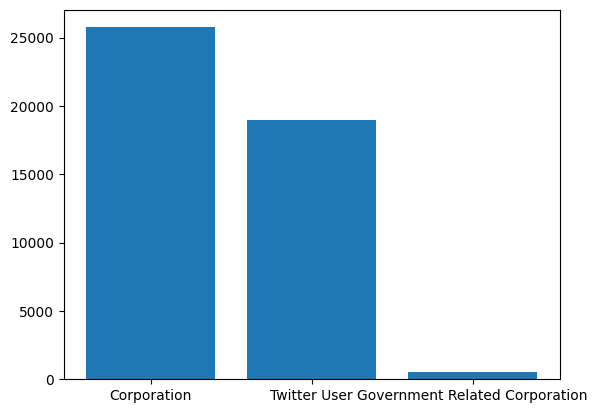

In [11]:
mentioned_type = list(itertools.chain.from_iterable(temp_df.mentioned_type.tolist()))
c = Counter(mentioned_type)
plt.bar(c.keys(), c.values(), align='center')
plt.show()

More than half of the tagging were about corporation, with more than 26000 times, compared with roughly 19000 times with twitter users. 

In [12]:
unique_text = df.tweet.unique()
print("Total unique tweet: ",len(unique_text), "\nTotal tweet: ",len(df))

Total unique tweet:  21047 
Total tweet:  21047


Looking at the stat, we can see that there is no duplicate tweet, therefore we would not have to pre-process those tweet

# Data Preprocessing

In [13]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)  
    return input_txt

In [14]:
remove_pattern('demonstration @hxat_276',"@[\w]*")

'demonstration '

### Remove all mention

In [15]:
df['tweet'] = df['tweet'].str.replace('@[\w]*', '', regex=True)
df['tweet']

0        Please check what happens to this no 940417705...
1        Network fluctuations and 4G Speed is pathetic....
2        This has been going on since 3rd... this absol...
3          I have done my recharge of 555 on 9709333370...
4        But when???Still I am not received any call fr...
                               ...                        
21042    I sent u my contact no. But still did not get ...
21043    dear   i have bn facing ur network problem for...
21044    rubbish i made many time   you didn't resolved...
21045    Why the caller tunes sound so horrible? if a s...
21046      what nonsense are u guys saying??? I'm getti...
Name: tweet, Length: 21047, dtype: object

### Remove non-character

In [16]:
df['tweet'] = df['tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
df['tweet']

0        Please check what happens to this no          ...
1        Network fluctuations and  G Speed is pathetic ...
2        This has been going on since  rd    this absol...
3          I have done my recharge of     on           ...
4        But when   Still I am not received any call fr...
                               ...                        
21042    I sent u my contact no  But still did not get ...
21043    dear   i have bn facing ur network problem for...
21044    rubbish i made many time   you didn t resolved...
21045    Why the caller tunes sound so horrible  if a s...
21046      what nonsense are u guys saying    I m getti...
Name: tweet, Length: 21047, dtype: object

### Remove blank tweet, this might due to Twitter web error

In [17]:
df['text_len'] = df.tweet.apply(len)
df[df['text_len'] == 0]

,username,date,tweet,mentions,text_len
20,omanmessi,10-06-2020,,"[ooredoooman, vodafonein]",0
153,kachharaarpit,10-06-2020,,"[vodafonein, pokharna, trai, rsprasad, dot_india]",0
757,misteragarwal,09-06-2020,,"[vodafonein, trai]",0
1659,logiciannumpy,09-06-2020,,"[mehharshil, vodafonein, erbmjha]",0
2289,rokia_el4zly,09-06-2020,,"[samazedan2, vodafonein, vodafonegroup]",0
2314,arnav06365316,09-06-2020,,"[mehharshil, najirpatel1985, vodafonein, brumb...",0
2342,bharatatoz009,09-06-2020,,"[mehharshil, srikanthbjp_, vodafonein, hinduit...",0
2408,mayankpatel1193,08-06-2020,,"[mehharshil, vodafonein, theangrylord]",0
3192,amardeep_1983,08-06-2020,,"[raziya_raz, vodafonein, reliancejio, jiocare]",0
5463,kaminokagod,07-06-2020,,"[vodafonein, nehaakhan16]",0


There arare 739 tweet containing mentions, since we removed all mentions in tweet, this tweet became blank

In [18]:
df['tweet'].replace('', np.nan, inplace=True)
df.dropna(subset=['tweet'], inplace=True)

In [19]:
df['text_len'] = df.tweet.apply(len)
df[df['text_len'] == 0]

,username,date,tweet,mentions,text_len


After process, there are none blank tweet left

### Remove traling space and convert all letter to lowercase

In [20]:
df["tweet"]= df["tweet"].str.strip() 
df["tweet"]= df["tweet"].str.lower() 
df['tweet']

0        please check what happens to this no          ...
1        network fluctuations and  g speed is pathetic ...
2        this has been going on since  rd    this absol...
3        i have done my recharge of     on            b...
4        but when   still i am not received any call fr...
                               ...                        
21042    i sent u my contact no  but still did not get ...
21043    dear   i have bn facing ur network problem for...
21044    rubbish i made many time   you didn t resolved...
21045    why the caller tunes sound so horrible  if a s...
21046    what nonsense are u guys saying    i m getting...
Name: tweet, Length: 21027, dtype: object

# User Workbench

In [21]:
class Workbench:
    def __init__(self, data: pd.DataFrame, topic=5):
        self.data = data
        self.topic = 5

    def _vectorize(self, return_data: bool=True, to_array:bool = True, vectorizer = TfidfVectorizer):
        self.vectorizer = vectorizer(analyzer='word',ngram_range=(1,3),\
                             stop_words='english', min_df = 0.0005, max_df=0.65)
        
        self.tfidf_matrix = self.vectorizer.fit_transform(self.data['tweet'])

        if to_array:
            self.tfidf_matrix = self.tfidf_matrix.toarray()
        
        if return_data:
            return self.tfidf_matrix


    def generate_wordcloud(self, cluster):
        # mask the wordcloud with the image of twitter logo as backgroud
        Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
        image_colors = ImageColorGenerator(Mask)
        
        # generate wordcloud with according backgroud
        wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(cluster)
        plt.figure(figsize=(10,20))
        plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
        plt.show()

    def identify_topics(self):
        km = KMeans(n_clusters=self.topic)
        km.fit(self.tfidf_matrix)
        clusters = km.labels_.tolist()
        tweets = {'Tweet': self.data["tweet"].tolist(), 'Cluster': clusters}
        frame = pd.DataFrame(tweets, index = [clusters])

        print(frame['Cluster'].value_counts()) 
        for cluster in range(self.topic):
            cluster_words = ' '.join(text for text in frame[frame['Cluster'] == cluster]['Tweet'])
            self.generate_wordcloud(cluster_words)
    
    def LDA_fitting(self):
        lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  
        lda_model.fit(self.tfidf_matrix)

        # get feature name
        feature_names = self.vectorizer.get_feature_names_out()
        n_top_words = 25
        for topic_idx, topic in enumerate(lda_model.components_):
            top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_idx]
            print(f"Topic :{topic_idx}:")
            print(", ".join(top_features))
            print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
1    13560
4     2643
0     2056
3     1739
2     1029
Name: count, dtype: int64


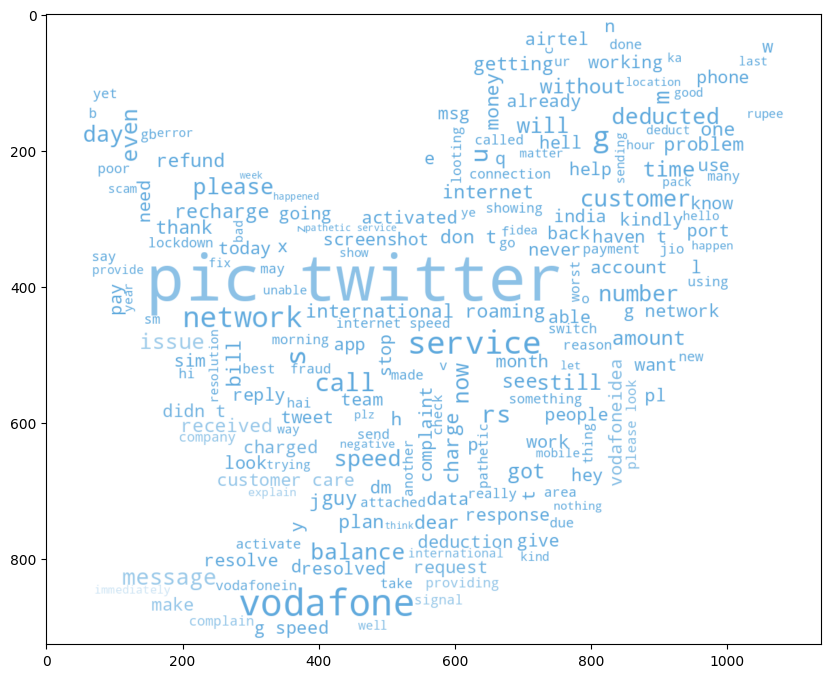

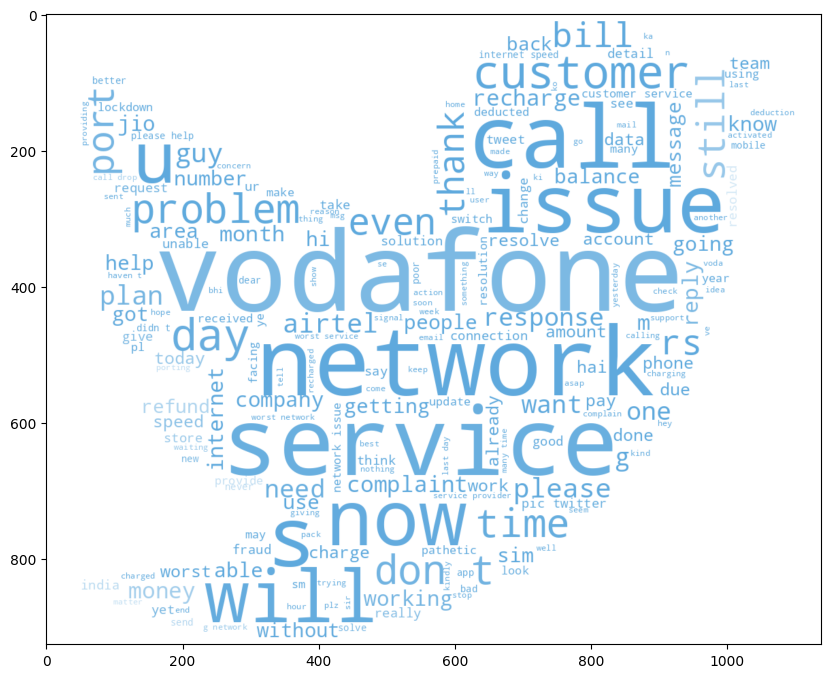

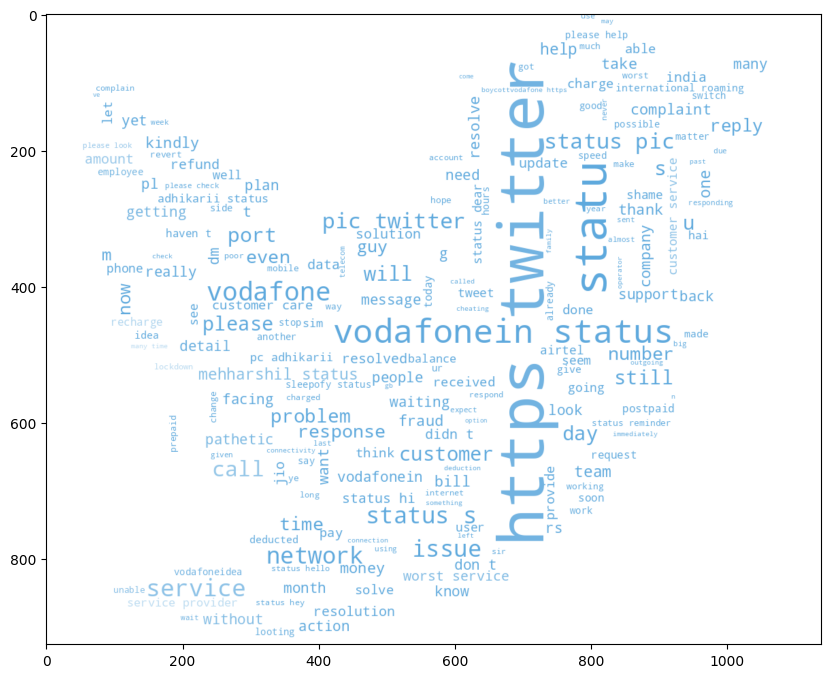

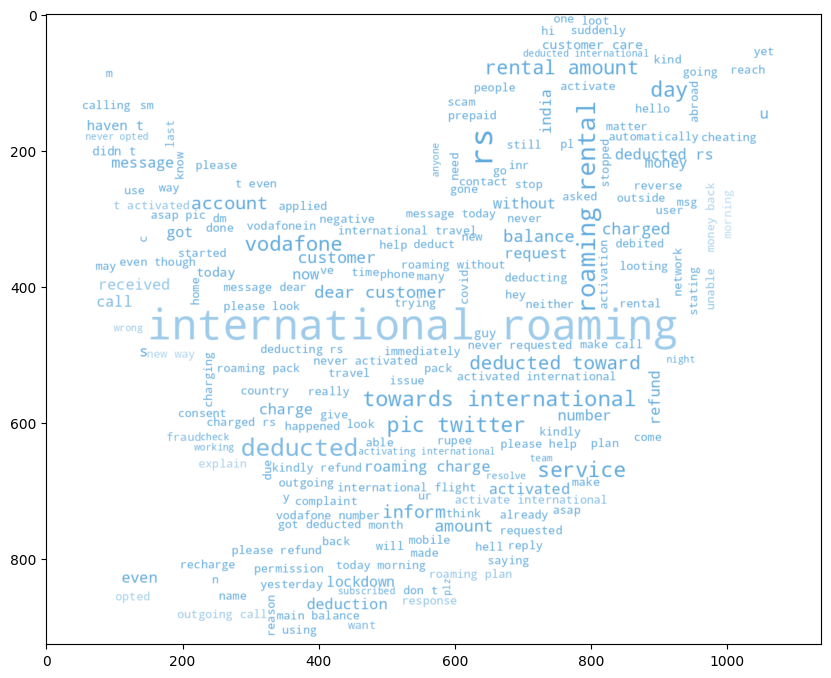

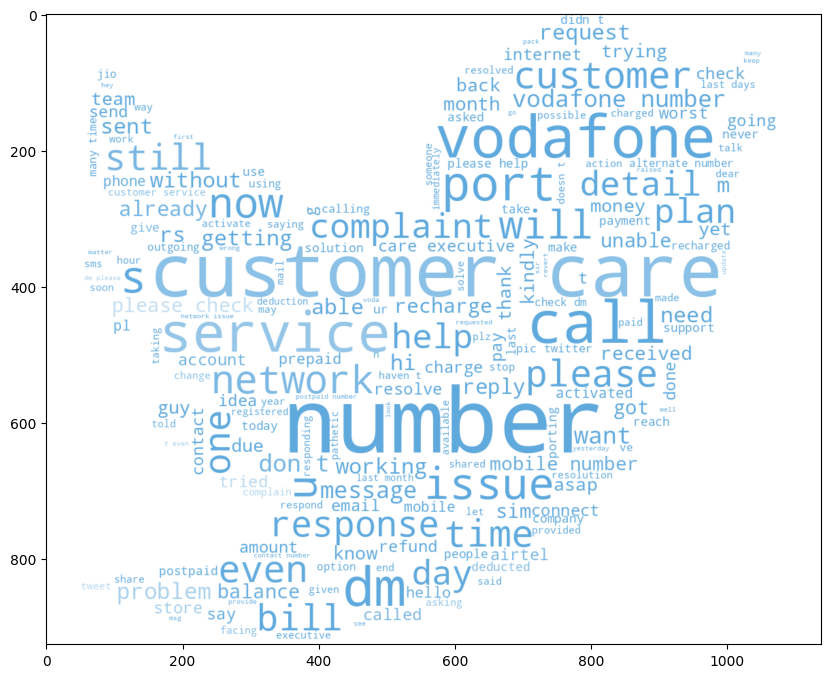

In [22]:
workbench = Workbench(data = df)
vect_word = workbench._vectorize()
workbench.identify_topics()

CLUSTERING 

In [23]:
workbench = Workbench(data = df)
vect_word = workbench._vectorize()
workbench.LDA_fitting()

Topic :0:
vodafone, number, plan, issue, customer, dm, details, don, sent, time, know, complaint, response, recharge, service, team, want, help, just, check, calls, services, reply, pay, update

Topic :1:
network, service, internet, vodafone, worst, hai, airtel, jio, speed, poor, port, area, sim, days, working, bad, pathetic, good, issue, customer, provider, services, worst network, data, use

Topic :2:
international, roaming, international roaming, rs, deducted, rental, balance, customer, charged, account, refund, money, rs deducted, roaming rental, international roaming rental, deducted international, deducted international roaming, activated, vodafone, care, charges, service, customer care, customers, deduction

Topic :3:
https, status, https twitter, https twitter com, com, twitter, twitter com, port, help, waiting, vodafone, reply, response, need, look, customer, matter, guys, care, like, respond, reach, idea, port number, look matter

Topic :4:
pic, pic twitter, pic twitter com, 

In [24]:
#coherence score -> gensim
#dùng wordcloud 
#chạy LSA

In [25]:
vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,1),\
                             stop_words='english', min_df = 0.0001, max_df=0.7)
vectorizer.fit(df['tweet'])
tfidf_matrix = vectorizer.transform(df["tweet"])
tfidf_matrix

<21027x5176 sparse matrix of type '<class 'numpy.float64'>'
	with 205859 stored elements in Compressed Sparse Row format>

# Word2vec test


In [26]:
# nlp = [nltk.word_tokenize(i) for i in df['tweet']]
# model = Word2Vec(nlp, sg=1, window=3, min_count=1, workers=4, epochs=1)        
# model.init_sims(replace=True) 

# model_result1 = model.wv.most_similar('service', topn =20)  
# print(model_result1)

In [27]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import nltk
import spacy
from sklearn.datasets import fetch_20newsgroups


nltk.download('stopwords')
nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])

#importing the Stopwords to use them
stop_words = stopwords.words('english')

#downloading the data
data = df['tweet']
 

def tokeniz(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

processed_data = list(tokeniz(data))
#Building Bigram & Trigram Models
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


#function to filter out stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#function to create bigrams
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#function to create trigrams
def create_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#function for lemmatization
def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_op



#removing stopwords, creating bigrams and lemmatizing the text
data_wo_stopwords = remove_stopwords(processed_data)
data_bigrams = create_bigrams(data_wo_stopwords)
data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB'])

#creating a dictionary
gensim_dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized

#building a corpus for the topic model
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]


#creating the LDA model 
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=5, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)


#calculating and displaying the coherence score

coherence_model_lda = CoherenceModel(
   model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Coherence Score:  0.35984045109833707


# Test on tfidf

In [ ]:
wcss =[]
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 49)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
print(wcss)

# plt.plot(range(1,11),wcss)
x = range(1,11)
kn = KneeLocator(x, wcss, curve='convex', direction='decreasing')
kn.plot_knee()
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
int_wc = {}
count = 0
for i in range(1,11):
  int_wc[i] = wcss[count]
  count += 1
int_wc

In [ ]:
tfidfss =[] 
for i in range(1,11):
    kmeanss = KMeans(n_clusters = i, init = 'k-means++', random_state = 49)
    kmeanss.fit(tfidf_matrix)
    tfidfss.append(kmeanss.inertia_)
# plt.plot(range(1,11),wcss)
x = range(1,11)
kn = KneeLocator(x, tfidfss, curve='convex', direction='decreasing')
kn.plot_knee()
plt.xlabel('Number of clusters')
plt.ylabel('TFIDFSS')
print(tfidfss)

Số lượng cluster phù hợp nhất dựa theo ineteria khi sử dụng phương pháp vectorize TF-IDF là 5

In [ ]:
int_tf = {}
count = 0
for i in range(1,11):
  int_tf[i] = tfidfss[count]
  count += 1
int_tf

In [ ]:

range_n_clusters = range(2,11)
silhouette_avg = []

for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(tfidf_matrix)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(tfidf_matrix, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
di = {}
count = 0
for i in range(2,11):
  di[i] = silhouette_avg[count]
  count += 1
di

In [ ]:
range_n_clusters = range(2,11)
silhouette_avg = []

for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(tfidf_matrix)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(tfidf_matrix, cluster_labels, random_state=29))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [ ]:
di = {}
count = 0
for i in range(2,11):
  di[i] = silhouette_avg[count]
  count += 1
di

Dựa trên kết quả silhouette score và inertia, chúng ta có:

TF-IDF:

Silhouette Score: dao động từ 0.039 đến 0.115.

Inertia: giảm từ khoảng 19,672 đến 18,507 khi số lượng cụm tăng từ 1 đến 10.
CountVectorizer:

Silhouette Score: dao động từ 0.039 đến 0.115.

Inertia: giảm từ khoảng 201,249 đến 185,507 khi số lượng cụm tăng từ 1 đến 10.

Dựa vào kết quả trên, không có sự khác biệt về Silhouette Score giữa TF-IDF và CountVectorizer. Tuy nhiên, khi xem xét Inertia, CountVectorizer cho thấy hiệu suất tốt hơn vì giá trị Inertia của nó thấp hơn.